## 1. Import packages:

In [1]:
#package import
import ziln_cltv as zltv

#importing data_preprocessing.py file for processing the kaggle data
from data_preprocessing import *

import os
import numpy as np
import pandas as pd
import tqdm
import multiprocessing


## 2. Download CLTV data from [Acquire Valued Shoppers Challenge](https://www.kaggle.com/competitions/acquire-valued-shoppers-challenge/data) competition:

### a. First install kaggle api using below command to get the data. Also ensure you get a API token file from your kaggle account & place it in C:/Users/Username/.kaggle folder . You need this to use the kaggle package to get competition data directly :

In [ ]:
%%capture
!pip install kaggle

### b. Download data from kaggle  to the `data` folder & extract it:

In [ ]:
%%capture
!kaggle competitions download -c acquire-valued-shoppers-challenge -p data

In [ ]:
import os
from zipfile import ZipFile

filename=os.listdir("data/")[0]
with ZipFile("data/"+filename, 'r') as zip:
    zip.printdir()
    zip.extractall("data/")

In [ ]:
%time
import gzip
import shutil
with gzip.open('data/transactions.csv.gz', 'rb') as f_in:
    with open('data/transactions.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

### c. Preprocessing:

* The competition data is very large containing information of customers of many companies. To make this process quicker, we are just extracting customer information from top 5 companies. And when we model CLTV, we would just be using customer data from a single company to make the analysis quicker. 
* You can choose to modify the below COMPANY variable to include as many or as less company id's as you want.
* Below runs the process() function from the preprocess.py file, which basically cleans the data & creates a modelling dataset.

In [ ]:

##You can either choose to get the modelling data for all company customer's or just a few. 
## The below COMPANIES variable is the list of companies you want to get the data for.
COMPANIES = ['104900040'
#     '10000', '101200010', '101410010', '101600010', '102100020','103600030'
#     '102840020', '103000030', '103338333', '103400030', '103600030',
#     '103700030', '103800030', '104300040', '104400040', '104470040',
#     '104900040', '105100050', '105150050', '107800070'
]


##May take 5-10mins depending on how many COMPANIES you run & how many CPU cores you have
p = multiprocessing.Pool(multiprocessing.cpu_count())
_ = p.map(process, COMPANIES)



## 3. Modelling CLTV:

##### The `ziln_cltv` package let's you model: 
1. **Lifetime value of the customer**: This should be the `target` column that you're fitting the data on. 
    * This package models the distribution of LTV given associated features as a mixture of zero point mass and lognormal distribution, which google refer to as the zero-inflated lognormal (ZILN) distribution, hence the name of the package `ziln_cltv`.
    * As per [Google's research](https://arxiv.org/abs/1912.07753), if you try to predict lifetime value beyond 1 year since the first date of purchase , your model performance deteriorates. So ideally, given the info your data has on customer's first date of purchase(like total purchase amount, type of products, customer characteristics), your `target` variable should be the total purchase amount by the customer in the year following customer's first date of purchase i.e total purchase amount from day 2 to day 365. 
    * However, you can model ltv beyond the first year of purchase if you have that data, but be sure to remember that the model performance deteriorates. 

2. **Churn probability of the customer**: This is the probability that the customer will return to make a purchase after their first purchase.
    * You dont need a separate `target` variable for this column as it's implied from the `target` variable mentioned above whether a customer churned or not
    * Depending on the timeframe of your `target` LTV variable, you should interpret the churn probability also for that timeframe. For ex., if your `target` variable is total purchase amount for day 2 to day 365, then your churn probability must be interpreted as churn probability for day 2 to day 365.

##### The main functions of this package are:
* **preprocess()** : function to label encode your categorical columns, sample the data &  creates train & test split 

* **fit_model()** : function that builds & trains your neural network CLTV model. Arguments like `layer`, `epochs`, `learning_rate`, `batch_size`, `callback_patience` & `callback_lr` lets you customise your network architecture if needed. The default network is identical to the one used in google's paper

* **ltv_performance()**: function to evaluate your LTV model. It calculates various metrics to evaluate:
                  1. Lifetime value prediction(regression): Spearman R, Decile MAPE, Gini 
                  2. Churn predictions(classification): Precision, Recall, AUC,  F1 Score
                  
* **model_predict()** : function to encode the categorical variables in your unseen data & make predictions. Useful when you have a new dataset that needs preprocessing to fit the model structure.

### 3a. Create encodings for categorical data & create train/test splits using `preprocess()`:


* The preprocess() function let's you either specify the path to your dataset or your a pandas DataFrame directly.
* `target_ltv`: Specify your `target` ltv variable in your data.
* `day1_purchaseAmt_col`: Column containing the total purchase ammount on the first date of purchase. This is required to calculate metrics later on. Include this in the `numerical_features` argument as well to ensure it's included in the model.
* `numerical_features` : List of numerical features in your model
* `categorical_features`: List of categorical features in your model that would be encoded.
* `sample_data`: Percentage of data to be used for modelling(both train & test sets). Use this if you want to model to test out the package or if your data is big & you only want to model a portion of your data. Value should be between 0 & 1 
* `testing_size`: Percentage of data to be used for testing.

Let's get started & import the ltv dataset for COMPANY="10000". 
Note that in this data, the calibration_value column contains the day 1 purchase amount of the customer. We will not be using that in the model, instead we'll be using the `log_calibration_value` column which is the log version of it. 
We would still need to specify it since it's used in calculating the baseline gain to compare the model performance. This is discussed in later sections.
We'll set the test dagta size to 30% & using the entirety of dataset for modelling(i.e. sample_data=1)  

In [2]:

CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']
TARGET="label"
DAY1_PURCHASEAMT_COL="calibration_value"

#regression "data/customer_level_data_company_103600030.csv"
#

feature_map, x_train, x_test, y_train, y_test, y0_test= zltv.preprocess(data= "data/customer_level_data_company_104900040.csv",
                                                                       target_ltv=TARGET,
                                                                       day1_purchaseAmt_col=DAY1_PURCHASEAMT_COL,
                                                                      numerical_features=NUMERIC_FEATURES,
                                                                      categorical_features=CATEGORICAL_FEATURES,
                                                                      sample_data=1,
                                                                      testing_size=0.2)


calibration_value was removed from the feature list since user has not specified it in `numerical_features` argument


* The preproces() function return you training & testing sets along with the mappings of your categorical encoded columns which is required to inform of the neural network structure.
* It also throws a message saying DAY1_PURCHASEAMT_COL="calibration_value" column was removed since its not in `numerical_features` argument. This is fine since we included the log version of it instead.

### 3b. Build & train the model using fit_model():

The `fit_model()` function lets you customise your neural network(although minimally) using the below arguments:
* `layers` (Default is [64,32,3]): List of nodes for each layer of the model including the output note. The default is [64.32]  which is what google used in their research which includes 2 hidden laters with 64 & 32 nodes along with the final output node with 3 nodes. This package lets you specify as many layers & corresponding nodes you want. If you have a very large dataset, you might need a bigger network with more layers & nodes.
* `epochs`(default is `100`)
* `learning_rate`(default is `0.0001`)
* `batch_size`(default is `1024`)
* `callback_patience`(default is `20`)
* `callback_lr`(default is `1e-06`)
* `verbose`(default is 0): setting it to 1 shows a progress bar & setting it to 2 shows loss for after epoch.

* `log_directory_name` : name of the folder where you want to store the training logs if you want to use tensorboard.

In [3]:

##If you want to run tensorboard uncomment the below line & run it:
# %tensorboard --logdir=logs

##Sometimes tensorboard keeps running even after closing the notebook. Run the below code to kill the tensorboard task:
#!taskkill /IM "tensorboard.exe" /F


In [4]:
LAYERS=[64,32]
EPOCHS=400
LEARNING_RATE=0.0002
BATCH_SIZE=1024
CALLBACK_PATIENCE=10
CALLBACK_LR=1e-06

model=zltv.fit_model(feature_map, x_train,y_train, x_test, y_test,
                    layers=LAYERS, 
                     epochs=EPOCHS, 
                     learning_rate=LEARNING_RATE,
                     batch_size=BATCH_SIZE,
                    callback_patience=CALLBACK_PATIENCE, 
                     callback_lr=CALLBACK_LR, 
                     verbose=0,
                     log_directory_name="logs")

C:\ProgramData\Miniconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 3c. Model Performance:

The package includes the `ltv_performance()` function that helps in evaluating your model using the below mentioned metrics:

* **LTV Prediction** : Spearman R, Decile MAPE, Gini 
* **Churn Probability prediction** : Precision, Recall, AUC,  F1 Score
* **Plots**: Gain chart, Decile lift chart

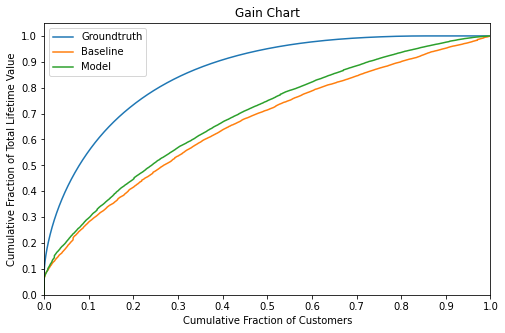

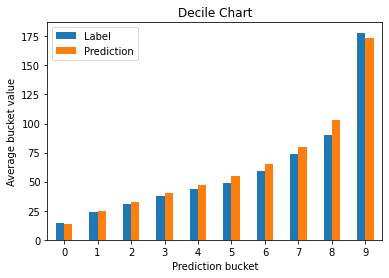

In [5]:
results, predictions= zltv.ltv_performance(model, x_test, y_test, y0_test)

In [6]:
results.transpose()

,0
Total Customers in data,49857.000000
Mean actual LTV,59.962151
Mean predicted LTV,63.465580
Percent of customers with non-zero LTV,0.840544
LTV Decile MAPE,0.081335
LTV Baseline GINI,0.452406
LTV Gini Coefficient,0.533898
LTV Spearman Correlation,0.393656
Mean actual Churn probability,0.840544
Mean predicted Churn probability,0.842870


* The Cumulative Gain chart plotted shows how the LTV predictions of the model(in green) compares with the baseline(orange) prediction ( the day 1 purchase amount ) and the lorenz curve(blue curve labelled Groundtruth). The closer the model curve is to the Lorenz curve, the better the model is at differentiating customers.
* Secondly, the decile chart basically sorts the data by prediction, then groups the data into 10 equal customer buckets & finds average actual & predicted values & plots them. The plot gives you an understanding of which customer cohort the model underestimates or overestimate LTV values.
* Other bunch of metrics evaluating the ltv as well as churn predictions are shown.

### 4. Predicting on new data which haven't been categorical encoded:


Getting predictions on new data is straightforward using the `model_predict()` function which takes in:
`model`: trained model
`data`: Either a pandas DataFrame or path to a csv or parquet file
`feature_map`: This is the same dictionary file you get when you ran the preprocess() function in the first step 2c.
`print_perforance`: Defaults to True & prints the above mentioned plots & evaluation metrics.

Now let's use the entirety of the modelling dataset to make predictions from scratch:

                                                    0
Total Customers in data                 249285.000000
Mean actual LTV                             73.856476
Mean predicted LTV                          63.608067
Percent of customers with non-zero LTV       0.842032
LTV Decile MAPE                              0.103536
LTV Baseline GINI                            0.576547
LTV Gini Coefficient                         0.644532
LTV Spearman Correlation                     0.395747
Mean actual Churn probability                0.842032
Mean predicted Churn probability             0.842544
ROC AUC                                      0.658997
PR AUC                                       0.905246
Precision                                    0.842847
Recall                                       0.999028
F1_Score                                     0.914316


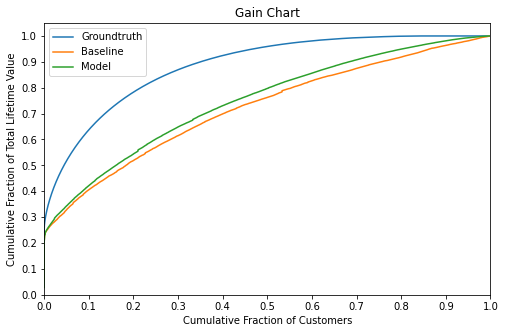

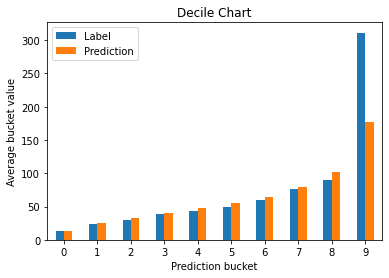

In [7]:
predictions= zltv.model_predict(model, 
                                data="data/customer_level_data_company_104900040.csv",
                                feature_map=feature_map,
                                print_performance=True)

#### For more info on how to evaluate these models refer to the [research paper](https://arxiv.org/abs/1912.07753) that explains ZILN loss in detail.